# Tiny Shakespeare

**Importación de librerías**
- `torch` y `torch.nn`: para construir y entrenar redes neuronales.
- `math`: funciones matemáticas (ej. raíz cuadrada).
- `matplotlib.pyplot`: para dibujar gráficos (visualizaciones).
- `torch.nn.functional`: funciones útiles (ej. activaciones).

In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F

**Cargar datos y crear vocabulario**: Lee el archivo de texto, crea la lista de caracteres únicos (vocabulario) y define funciones para convertir entre caracteres y números.
- `encode`: convierte string a lista de índices.
- `decode`: convierte lista de índices a string.
- `data`: es un tensor con todo el texto codificado, listo para entrenar.

In [2]:
# Cargar texto 
with open('../Datos/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Obtener caracteres únicos
chars = sorted(list(set(text))) # Toma todos los caracteres del texto sin repetición, los convierte en lista y los ordena alfabéticamente
vocab_size = len(chars)

# Diccionarios
cha_to_num = { ch:i for i, ch in enumerate(chars) } # Cada carácter único se asocia con un número entero
num_to_char = { i:ch for i, ch in enumerate(chars) } # Convierte números a caracteres

def encode(s):
    return [cha_to_num[c] for c in s]

def decode(l):
    return ''.join([num_to_char[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

print(f"Vocab size: {vocab_size}")


Vocab size: 65


**Crear batches para entrenamiento**: `get_batch` selecciona sub-secuencias aleatorias del texto para formar un batch (conjunto) de entrenamiento.
- `X`: entradas (secuencias).
- `y`: objetivos, que son las mismas secuencias desplazadas una posición (el siguiente carácter que el modelo debe predecir).

Los batches permiten entrenar con muestras variadas en cada paso.

In [3]:
# Selecciona aleatoriamente subsecuencias de longitud block_size
def get_batch(data, batch_size, block_size):
    ix = torch.randint(0, len(data) - block_size - 1, (batch_size,))
    X = torch.stack([data[i:i+block_size] for i in ix]) # contiene secuencias de entrada
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # contiene la misma secuencia pero desplazada un carácter adelante, que será la salida a predecir
    return X, y

**Embeddings de tokens**: `Token_to_Embedding` transforma índices (números) en vectores densos de tamaño `d_model`.
- Las redes no trabajan directamente con números discretos; transformamos each token en un vector que la red puede procesar.

In [4]:
# Convierte cada entero (carácter) en un vector de dimensión d_model
class Token_to_Embedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        # Llama al constructor de la clase base nn.Module
        super().__init__()
        # Crea una capa de embedding que mapea cada entero a un vector de dimensión d_model
        self.embedding = nn.Embedding(vocab_size, d_model)

# Método forward que realiza la transformación de enteros a embeddings
    def forward(self, x):
        """
        x: LongTensor of shape (batch, seq_len)
        returns: Tensor of shape (batch, seq_len, d_model)
        """
        return self.embedding(x)

**Codificación posicional**: `PositionalEncoding` añade información de posición a cada token usando senos y cosenos.
- Los embeddings por sí solos no contienen el orden de la secuencia; la codificación posicional permite al modelo distinguir la posición de cada token.

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, d_model):
        # Llama al constructor de la clase base nn.Module
        super().__init__()

         # Creamos un tensor de ceros con tamaño (max_seq_len, d_model) el cual almacenará los vectores de codificación posicional para cada posición y cada dimensión del embedding
        pe = torch.zeros(max_seq_len, d_model)
        # Representa la posición de cada token en la secuencia
        position = torch.arange(0, max_seq_len).unsqueeze(1)

        # Calcula los términos de frecuencia para las funciones seno y coseno
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        # Asigna valores de seno y coseno a las posiciones correspondientes en el tensor de codificación posicional
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Registra el tensor de codificación posicional como un buffer del módulo
        self.register_buffer("pe", pe)

# Método forward que añade la codificación posicional a los embeddings de entrada   
    def forward(self, x):
        # x: Tensor of shape (batch, seq_len, d_model)
         # Obtiene las dimensiones del tensor de entrada
        B, T, _ = x.shape
        # Devuelve la codificación posicional correspondiente a la longitud de la secuencia de entrada, expandida para coincidir con el tamaño del batch
        return self.pe[:T].unsqueeze(0).expand(B, T, -1)


**Ejemplo rápido**: esta celda crea un batch falso para mostrar las formas (shapes) de los tensores después de pasar por embeddings y codificación posicional.

In [7]:
# Hyperparametros
vocab_size = 50    # Tamaño del vocabulario (número de caracteres únicos)
d_model = 64       # Dimensión del embedding
max_seq_len = 32   # Longitud máxima de la secuencia

# Datos de entrada de ejemplo
B, T = 2, max_seq_len        # Batch size y longitud de la secuencia

# Crear un batch de secuencias aleatorias
x = torch.randint(
    low=0,  # Valor exclusivo más bajo
    high=vocab_size, # Valor exclusivo más alto
    size=(B, T), # Tamaño del tensor de salida
    dtype=torch.long # Tipo de datos del tensor
)
print(x)

# Crear instancias de las clases de embedding y codificación posicional
token_emb = Token_to_Embedding(vocab_size, d_model)
pos_emb = PositionalEncoding(max_seq_len, d_model)

# Obtener embeddings y codificaciones posicionales
tok = token_emb(x)    # (B, T, d_model) Convierte los tokens en embeddings
pos = pos_emb(tok)    # (B, T, d_model) Obtiene las codificaciones posicionales
out = tok + pos       # (B, T, d_model) Suma los embeddings y las codificaciones posicionales

print("Token embedding shape:", tok.shape)
print("Positional embedding shape:", pos.shape)
print("Final embedding shape:", out.shape)

tensor([[17,  0, 48, 31, 27, 47, 21, 47, 45, 24, 24, 37, 24, 30, 37, 18, 43, 40,
         20, 17, 40,  0, 31, 26, 43, 17, 11, 16, 48,  4,  8,  2],
        [45, 45, 46, 22, 17, 26,  9, 27, 28, 45, 27, 14, 39, 34, 37, 17, 36, 18,
         34, 16, 27,  1, 13, 44, 44, 12, 42, 33, 35, 41, 21,  1]])
Token embedding shape: torch.Size([2, 32, 64])
Positional embedding shape: torch.Size([2, 32, 64])
Final embedding shape: torch.Size([2, 32, 64])


**Visualizar codificación posicional**: muestra la matriz de codificación posicional como imagen para entender cómo varían las componentes según la posición.
- Cada fila corresponde a una posición en la secuencia; cada columna a una dimensión del embedding.

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
          1.3335e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
          2.6670e-04,  1.0000e+00],
        ...,
        [-6.6363e-01, -7.4806e-01,  2.4180e-01,  ...,  9.9999e-01,
          3.8672e-03,  9.9999e-01],
        [-9.8803e-01,  1.5425e-01, -4.8440e-01,  ...,  9.9999e-01,
          4.0006e-03,  9.9999e-01],
        [-4.0404e-01,  9.1474e-01, -9.5073e-01,  ...,  9.9998e-01,
          4.1339e-03,  9.9999e-01]])


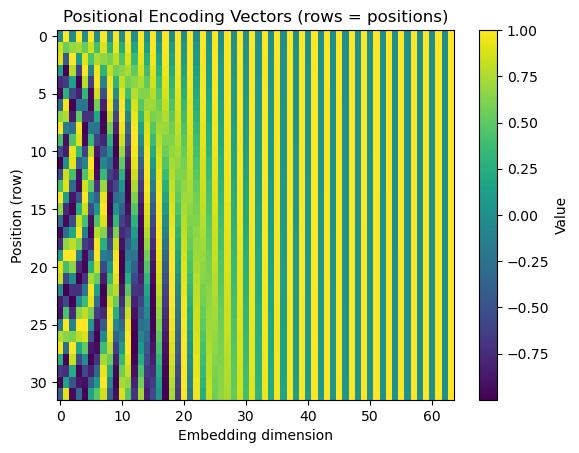

In [8]:
# pos[0] tiene tamaño (32, 64)

# Visualizar las codificaciones posicionales
pe = pos[0]  # filas = posiciones, columnas = dimensiones del embedding

print(pe)

plt.figure()
plt.imshow(pe, aspect="auto")
plt.xlabel("Embedding dimension")
plt.ylabel("Position (row)")
plt.title("Positional Encoding Vectors (rows = positions)")
plt.colorbar(label="Value")
plt.show()

**Atención por producto escalar escalado (Scaled Dot-Product Attention)**: esta clase calcula los scores de atención entre queries y keys, aplica una máscara causal (para que cada posición no vea el futuro), usa softmax para normalizar y calcula la suma ponderada de valores.
- Devuelve también los pesos de atención (útiles para interpretar lo que mira el modelo).

In [9]:
class ScaledDotProductAttention(nn.Module):
    # Inicializa la clase de atención con el tamaño de la dimensión de las claves
    def __init__(self, d_k):
        # Llama al constructor de la clase base nn.Module
        super().__init__()
        # Almacena la dimensión de las claves
        self.d_k = d_k

    # Método forward que calcula la atención con máscara causal
    def forward(self, Q, K, V):
        """
        Q, K, V: tensors of shape (B, T, d_k)
        returns: tensor of shape (B, T, d_v)
        """

        # Obtiene las dimensiones de los tensores de entrada
        B, T, d_k = Q.shape

        # Paso 1: Calcular las puntuaciones de atención sin procesar
        # (B, T, d_k) @ (B, d_k, T) -> (B, T, T)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

        # Paso 2: Crear máscara causal
        # ta: (T, T)
        mask = torch.tril(torch.ones(T, T, device=Q.device))

        # Paso 3: Aplicar la máscara causal
        # Convierte la máscara para que las posiciones no permitidas tengan un valor de -inf
        scores = scores.masked_fill(mask == 0, float("-inf"))

        #Paso 4: Calcular los pesos de atención aplicando softmax
        attn_weights = torch.softmax(scores, dim=-1)

        # Paso 5: Calcular la salida ponderada
        # (B, T, T) @ (B, T, d_v) -> (B, T, d_v)
        output = torch.matmul(attn_weights, V)

        return output, attn_weights


**Multi-Head Attention**: combina varias atenciones en paralelo (cabezas) para que el modelo capture diferentes tipos de relaciones entre tokens.
- Proceso: proyectar entradas a Q/K/V, separar en `n_heads`, aplicar atención a cada cabeza, concatenar resultados y proyectar de vuelta.
- Devuelve también los pesos de atención por cabeza.

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        assert d_model % n_heads == 0, "d_model must be divisible by n_heads" # Asegura que d_model sea divisible por n_heads
        self.d_model = d_model   # Dimensión del modelo
        self.n_heads = n_heads  # Número de cabezas de atención
        self.head_dim = d_model // n_heads # Almacena la dimensión de cada cabeza

        #Proyectores lineales para Q, K, V
        self.W_q = nn.Linear(d_model, d_model) 
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Proyector lineal final de salida
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        """
        x: Tensor of shape (B, T, d_model)
        returns: Tensor of shape (B, T, d_model)
        """

        B, T, _ = x.shape # Obtiene las dimensiones del tensor de entrada

        # 1. Proyecciones lineales
        Q = self.W_q(x)  # (B, T, d_model)
        K = self.W_k(x)
        V = self.W_v(x)

        # 2. Cambiar forma para múltiples cabezas
        # (B, T, d_model) -> (B, T, n_heads, head_dim)
        Q = Q.view(B, T, self.n_heads, self.head_dim)
        K = K.view(B, T, self.n_heads, self.head_dim)
        V = V.view(B, T, self.n_heads, self.head_dim)

        # 3. Transponer para facilitar el cálculo de la atención
        # (B, T, n_heads, head_dim) -> (B, n_heads, T, head_dim)
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # 4. Producto punto escalado con atención causal
        # (B, n_heads, T, T)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim) 

        # Crear y aplicar máscara causal
        mask = torch.tril(torch.ones(T, T, device=x.device)) # Máscara triangular inferior para atención causal
        scores = scores.masked_fill(mask == 0, float("-inf")) # Aplica la máscara

        # Calcular los pesos de atención
        attn_weights = torch.softmax(scores, dim=-1)

        # (B, n_heads, T, head_dim)
        out = torch.matmul(attn_weights, V) # Salida de cada cabeza de atención

        # 5. Concatenar cabezas
        # (B, n_heads, T, head_dim) -> (B, T, n_heads, head_dim)
        out = out.transpose(1, 2).contiguous() # Transpone para juntar las cabezas

        # (B, T, d_model)
        out = out.view(B, T, self.d_model) # Concatenar las cabezas

        # 6. Proyeccion lineal final
        out = self.W_o(out)

        return out, attn_weights


**Bloque Transformer (Block)**: combina Multi-Head Attention y una red feed-forward con normalizaciones y conexiones residuales.
- Las conexiones residuales (`x = x + sublayer`) ayudan al entrenamiento profundo.
- `LayerNorm` estabiliza la activación.

In [14]:
class Block(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        # 1. Normalización de capa
        self.ln1 = nn.LayerNorm(d_model) 
        self.ln2 = nn.LayerNorm(d_model) 

        # 2. Multi-Head Attention
        self.mha = MultiHeadAttention(d_model, n_heads) 

        # 3. Feed-Forward Network
        self.ffn = nn.Sequential( 
            nn.Linear(d_model, 4 * d_model),   # Expande la dimensión
            nn.GELU(), # Función de activación GELU
            nn.Linear(4 * d_model, d_model) # Reduce la dimensión de vuelta a d_model
        )

    def forward(self, x):
        """
        x: Tensor of shape (B, T, d_model)
        returns: Tensor of shape (B, T, d_model)
        """

        # Subcapas del bloque Transformer
        attn_out, _ = self.mha(self.ln1(x)) 
        x = x + attn_out   # Conexión residual

        # Subcapas del bloque Transformer
        ffn_out = self.ffn(self.ln2(x)) 
        x = x + ffn_out    # Conexión residual

        return x


**Modelo de lenguaje GPT básico**: `GPTLanguageModel` junta embeddings, bloques transformer y una cabeza lineal que proyecta a la dimensión del vocabulario para obtener logits (valores antes de softmax).
- La salida `logits` se usa para calcular probabilidades del siguiente token.

In [15]:
class GPTLanguageModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_seq_len,
        d_model,
        n_heads,
        n_layers
    ):
        super().__init__()

        # 1. Token + Position embeddings
        self.token_emb = Token_to_Embedding(vocab_size, d_model) # Capa de embedding de tokens
        self.pos_emb = PositionalEncoding(max_seq_len, d_model) # Capa de codificación posicional

        # 2. Transformer blocks
        self.blocks = nn.ModuleList(
            [Block(d_model, n_heads) for _ in range(n_layers)] # Crear una lista de bloques Transformer
        )

        # 3. Normalización final
        self.ln_f = nn.LayerNorm(d_model) # Normalización de capa final

        # 4. Language modeling head
        self.head = nn.Linear(d_model, vocab_size, bias=False) # Proyecta a la dimensión del vocabulario

    def forward(self, idx):
        """
        idx: LongTensor of shape (B, T)
        returns: logits of shape (B, T, vocab_size)
        """
        
        B, T = idx.shape # Obtiene las dimensiones del tensor de entrada

        # Token embeddings
        tok_emb = self.token_emb(idx)           # (B, T, d_model)

        # Positional embeddings
        # Obtener las codificaciones posicionales correspondientes
        pos_emb = self.pos_emb(tok_emb)         # (B, T, d_model)

        # Combine embeddings
        # Suma los embeddings de tokens y las codificaciones posicionales
        x = tok_emb + pos_emb                   # (B, T, d_model)

        # Transformer blocks
        for block in self.blocks: # Itera sobre cada bloque Transformer
            x = block(x) # (B, T, d_model)

        # Normalización final
        x = self.ln_f(x)                        # (B, T, d_model)

        # Proyección al vocabulario
        logits = self.head(x)                   # (B, T, vocab_size)

        return logits

**Hiperparámetros e inicialización**: se definen valores (batch_size, block_size, dimensiones, número de capas/cabezas) y se crea el modelo.
- `device`: selecciona `cuda` si hay GPU disponible, sino `cpu`.

In [16]:
# Hiperparámetros
batch_size = 64 # Tamaño del batch
block_size = 256 # Longitud de la secuencia
d_model = 384 # Dimensión del embedding
n_heads = 6 # Número de cabezas de atención
n_layers = 6  # Número de bloques Transformer
lr = 3e-4 # Tasa de aprendizaje
max_epochs = 10  # Número de épocas de entrenamiento

vocab_size = len(set(text))  # Tamaño del vocabulario basado en caracteres únicos

# Crear el modelo GPT
model = GPTLanguageModel(
    vocab_size=vocab_size,
    max_seq_len=block_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers
)

# Mover el modelo a GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

GPTLanguageModel(
  (token_emb): Token_to_Embedding(
    (embedding): Embedding(65, 384)
  )
  (pos_emb): PositionalEncoding()
  (blocks): ModuleList(
    (0): Block(
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=384, out_features=384, bias=True)
        (W_k): Linear(in_features=384, out_features=384, bias=True)
        (W_v): Linear(in_features=384, out_features=384, bias=True)
        (W_o): Linear(in_features=384, out_features=384, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=384, out_features=1536, bias=True)
        (1): GELU(approximate=none)
        (2): Linear(in_features=1536, out_features=384, bias=True)
      )
    )
    (1): Block(
      (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAtten

**Cargar modelo pre-entrenado**: si ya tienes un archivo `model.pth`, carga los pesos guardados.
- `map_location=torch.device('cpu')` fuerza la carga en CPU (útil si no se tiene GPU).
- Reemplaza la ruta si el archivo está en otra ubicación.

In [17]:
path_pth = "C:\\Users\\brend\\Documents\\Github\\Deep-Learning\\Proyecto_2\\model.pth"

model = torch.load(path_pth, map_location=torch.device('cpu'))

**Generación de texto (inferencia)**: `generate_text` toma un texto inicial, lo codifica, y va generando nuevos caracteres uno por uno usando el modelo entrenado.
- `@torch.no_grad()` evita calcular gradientes (no entrenamos).
- `temperature` controla diversidad: valores bajos -> texto más determinista; altos -> más aleatorio.
- Se usa muestreo (`torch.multinomial`) para elegir el siguiente token según las probabilidades.

In [18]:
# Inferencia / Generación de texto
@torch.no_grad()
def generate_text(model, start_text, length=200, temperature=1.0):
    """
    Genera texto a partir de un prompt inicial.

    Args:
        model: modelo entrenado GPTLanguageModel
        start_text: texto inicial (string)
        length: número de caracteres a generar
        temperature: controla la aleatoriedad en la predicción
    Returns:
        texto generado (string)
    """
    model.eval() # Pone el modelo en modo evaluación
    idx = torch.tensor(encode(start_text), dtype=torch.long, device=device).unsqueeze(0)  # (1, len)

    # Generar caracteres uno por uno
    for _ in range(length):
        # Limitar la secuencia a block_size
        idx_cond = idx[:, -block_size:] # (1, block_size)
        logits = model(idx_cond)  # (1, T, vocab_size)
        logits = logits[:, -1, :] / temperature  # último token
        probs = torch.softmax(logits, dim=-1) # distribución de probabilidad sobre el vocabulario
        next_idx = torch.multinomial(probs, num_samples=1)  # muestreo
        idx = torch.cat([idx, next_idx], dim=1) # Añade el nuevo carácter generado

    # Devuelve el texto generado decodificado
    return decode(idx[0].tolist())

**Ejemplo de generación**: usa la función anterior con una letra o palabra inicial para obtener texto generado por el modelo.

In [19]:
start_word = "R"  # palabra inicial
generated = generate_text(model, start_word, length=150, temperature=0.8) # Genera 150 caracteres con temperatura 0.8
print("=== Texto generado ===")
print(generated)

=== Texto generado ===
RGARET:
But repetition of what thou hast marr'd;
That will I make before I let thee go.

GLOUCESTER:
Wert thou not banished on pain of death?

QUEEN MA


**Bucle de entrenamiento**: esta sección prepara el optimizador, la función de pérdida y ejecuta el entrenamiento por un número de épocas.
- `optimizer.zero_grad()`: limpia gradientes.
- `loss.backward()`: calcula gradientes.
- `optimizer.step()`: actualiza parámetros.
- `avg_loss`: pérdida promedio por época (útil para monitorear progreso).

In [ ]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Hiperparámetros
batch_size = 64
block_size = 256
d_model = 384
n_heads = 6
n_layers = 6  
lr = 3e-4
max_epochs = 10 

vocab_size = len(set(text))  # o el tamaño del vocabulario basado en caracteres únicos

# Preparar el modelo y el optimizador
model = GPTLanguageModel(
    vocab_size=vocab_size,
    max_seq_len=block_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers
)

device = "cuda" if torch.cuda.is_available() else "cpu" # Mover el modelo a GPU si está disponible
model.to(device) 

optimizer = optim.AdamW(model.parameters(), lr=lr) # Optimizador AdamW
criterion = CrossEntropyLoss() # Función de pérdida de entropía cruzada

# Entrenamiento
for epoch in range(max_epochs): 
    model.train() # Pone el modelo en modo entrenamiento
    total_loss = 0.0 # Inicializa la pérdida total

    # Iteramos sobre un número fijo de batches por época
    n_batches = len(data) // batch_size # Número de batches por época
    for _ in tqdm(range(n_batches), desc=f"Epoch {epoch+1}/{max_epochs}"): # Itera sobre los batches
        X, y = get_batch(data, batch_size, block_size) # Obtiene un batch de datos
        X, y = X.to(device), y.to(device) # Mueve los datos a la GPU si está disponible

        optimizer.zero_grad() # Resetea los gradientes

        # Forward pass
        logits = model(X)  # (B, T, vocab_size)
        # (B*T, vocab_size) vs (B*T,)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1)) # Calcula la pérdida

        loss.backward() # Backpropagation
        optimizer.step() # Actualiza los parámetros del modelo

        total_loss += loss.item() # Acumula la pérdida

    avg_loss = total_loss / n_batches # Calcula la pérdida promedio por época
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}") # Imprime la pérdida promedio por época
